In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
import copy
from collections import Counter

<h2>Game modeling</h2>

In [2]:
def stringify(seq):
    string = ''
    for n in seq:
        string+=str(n)
    return string

In [3]:
n = 12
sequence_list = np.array([np.array(list(bin(i)[3:]),dtype=np.int32) for i in range(2**n, 2**(n+1))])
len(sequence_list)

4096

In [4]:
#Hidden Rules
rule1 = [0,0,1,1]
rule2 = [1,1,0,1]
reward1 = 5
reward2 = 10
def estimate_cost(sequence):
    reward = 0
    for k in range(n-3):
        if np.all(sequence[k:k+4]==rule1):
            reward += reward1
        elif np.all(sequence[k:k+4]==rule2):
            reward += reward2
    return reward

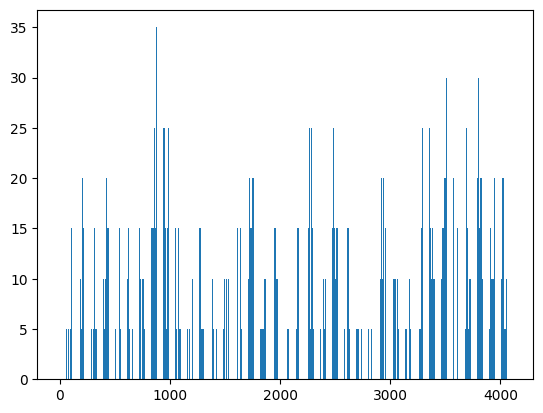

877
[0 0 1 1 0 1 1 0 1 1 0 1]
35


In [5]:
sequence_cost = []
for sequence in sequence_list:
    sequence_cost.append(estimate_cost(sequence))
sequence_cost = np.array(sequence_cost)

plt.bar([i for i in np.arange(len(sequence_list))],sequence_cost,width=0.5)
plt.show()
ma = np.argmax(sequence_cost)
print(ma)
print(sequence_list[ma])
print(sequence_cost[ma])

In [6]:
#20 best solutions 
sorted(range(len(sequence_cost)), key=lambda i: sequence_cost[i], reverse=True)[:20]

[877,
 845,
 1754,
 1755,
 1757,
 1773,
 1901,
 2925,
 3437,
 3501,
 3508,
 3509,
 3510,
 3511,
 3514,
 3515,
 3517,
 3546,
 3547,
 3549]

<h2>Compressive Sensing</h2>
<h3>Ideal compressive sensing</h3>

In [7]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

In [8]:
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats

In [9]:
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats

In [10]:
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats

In [11]:
def create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size):
    """
    Generate specific patterns for 5 modes.
    """
    pats = []
    temp_pats = create_specific_patterns4(mode1, mode2, mode3, mode4, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode5] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats

In [12]:
def create_specific_patterns8(mode1, mode2, mode3, mode4, mode5, mode6, mode7, mode8, size):
    """
    Generate specific patterns for 8 modes.
    """
    pats = []
    temp_pats = create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode6] = bin_to_pattern(str(k))[0]
            for l in range(2):
                p_prime2 = copy.deepcopy(p_prime)
                p_prime2[mode7] = bin_to_pattern(str(l))[0]
                for m in range(2):
                    p_prime3 = copy.deepcopy(p_prime2)
                    p_prime3[mode8] = bin_to_pattern(str(m))[0]
                    pats.append(p_prime3)
    return pats

In [177]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

472.14549819560654
877
[0 0 1 1 0 1 1 0 1 1 0 1]
472.14549819560654


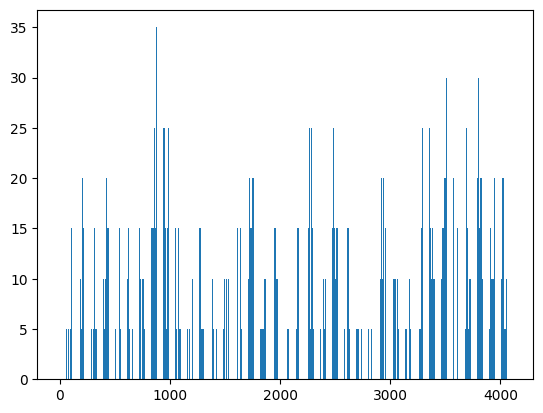

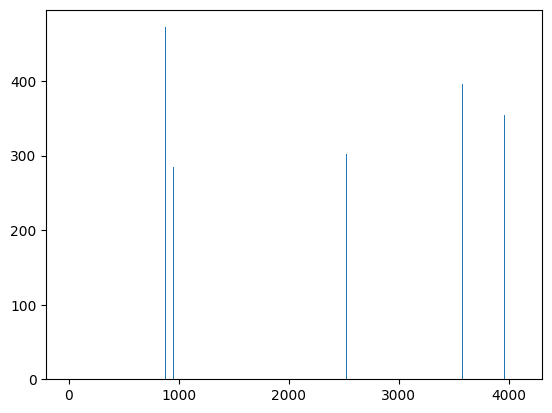

In [26]:
#Quadruplets measurements
all_pat = []
y = []

all_pat = []
for i in range(n):
    for j in range(i+1,n):
        for k in range(j+1,n):
            for l in range(k+1,n):
                all_pat += create_specific_patterns4(i,j,k,l,n)
# for i in range(n-3):
#     all_pat += create_specific_patterns4(i,i+1,i+2,i+3,n)

# print(len(all_pat))

Phi = np.array([dev_pattern(p) for p in all_pat])
y = np.array(Phi * np.matrix(sequence_cost).T).T[0]

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

print(coefficients[877])
ma = np.argmax(coefficients)
print(ma)
print(sequence_list[ma])
print(coefficients[ma])

plt.bar([i for i in np.arange(len(sequence_list))],sequence_cost,width=0.5)
plt.show()
plt.bar([i for i in np.arange(len(coefficients))],coefficients,width=5)
plt.show()
y_ideal = y

<h3>Estimated measurement monte carlo</h3>

In [14]:
import panel as pn

pn.extension('ipywidgets',sizing_mode='stretch_width')  
tabs = pn.layout.Tabs()
tabs.show()

/tmp/ipykernel_261979/3945579368.py:3: UserWarning: Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.
  pn.extension('ipywidgets',sizing_mode='stretch_width')


Launching server at http://localhost:38097


In [124]:
#Sample from possible sequences (be careful not to take the solution already)
sample_index = np.random.randint(0,len(sequence_list),200)

for i in sorted(range(len(sequence_cost)), key=lambda i: sequence_cost[i], reverse=True)[:20]:
    if i in sample_index:
        print(i)

seq_sample = sequence_list[sample_index]
seq_sample_cost = sequence_cost[sample_index]

sequence_cost_spectrum = np.zeros_like(sequence_cost)
sequence_cost_spectrum[sample_index] = sequence_cost[sample_index]
# plt.bar(range(len(sequence_cost)), sequence_cost_spectrum)
# plt.show()

3501


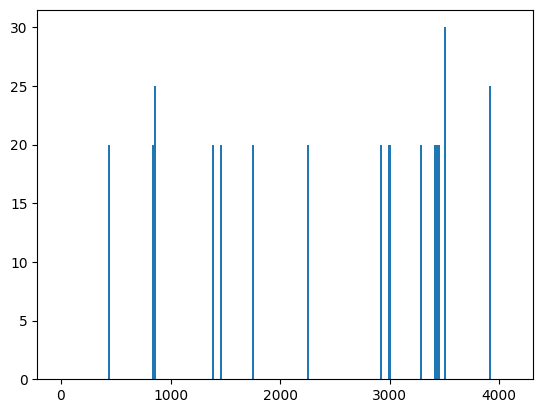

In [125]:
# thresh = sequence_cost_spectrum.max()
thresh = 20
sequence_cost_spectrum[sequence_cost_spectrum<thresh]=0
plt.bar(range(len(sequence_cost)), sequence_cost_spectrum,width=20)
plt.show()
# non_zero_elements = sequence_cost_spectrum[sequence_cost_spectrum != 0]
# len(non_zero_elements)

In [131]:
tabs.clear()

In [133]:
#Random
y = []

Phi = np.random.rand(250,4096)
y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]

y = np.array(y)

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

fig = plt.Figure(figsize=(5, 5))
ax = fig.subplots()
ax.bar([i for i in np.arange(len(coefficients))],coefficients,width=20)
ax.set_xlabel("Good optimums " + str(np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])))
tabs.append(pn.panel(fig,name="Random"))

<function matplotlib.pyplot.show(close=None, block=None)>

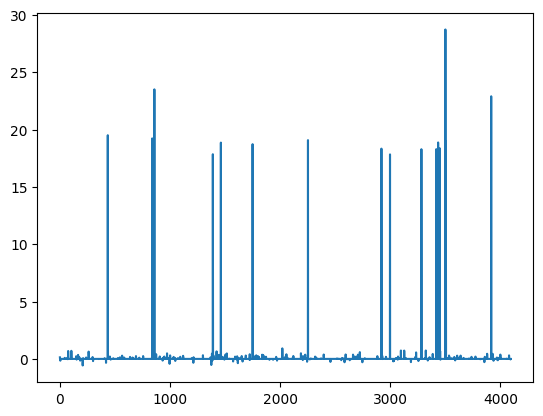

In [127]:
import pyproximal
import pylops

Aop = pylops.MatrixMult(Phi)
Aop.explicit = False

x = np.array(sequence_cost_spectrum)
y = Aop * x

f = pyproximal.AffineSet(Aop, y, niter=20)
g = pyproximal.L1()

xinv_early = pyproximal.optimization.primal.ADMM(f, g, np.zeros_like(x),
                                                 0.1, niter=300, show=False)[0]
plt.plot(xinv_early)
plt.show

In [128]:
xinv_early[xinv_early<3.5]=0
print(np.linalg.norm(xinv_early-x))
print(np.linalg.norm(np.array(coefficients)-x))

np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(xinv_early)[0])

6.57928405604645
57.696161407756264


array([3501])

In [211]:
#Nearest neighbor quadruplets
all_pat = []
y = []

for i in range(n-3):
    all_pat += create_specific_patterns4(i,i+1,i+2,i+3,n)

Phi = np.array([dev_pattern(p)/np.sqrt(16) for p in all_pat]) 
y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]
y = np.array(y)

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

fig = plt.Figure(figsize=(5, 5))
ax = fig.subplots()
ax.bar([i for i in np.arange(len(coefficients))],coefficients,width=20)
ax.set_xlabel("Good optimums " + str(np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])))
tabs.append(pn.panel(fig,name="NN quadruplets"))

In [ ]:

# r = np.matrix(y).T.copy()

# for _ in range(3):
#     t = np.argmax(Phi.T * r)
#     print(t)
#     r -= np.matrix(Phi.T[t]).T * 10

3437
3437
3510


In [178]:
#All quadruplets
all_pat = []
y = []

all_pat = []
for i in range(n):
    for j in range(i+1,n):
        for k in range(j+1,n):
            for l in range(k+1,n):
                all_pat += create_specific_patterns4(i,j,k,l,n)

Phi = np.array([dev_pattern(p) for p in all_pat])
y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]

y = np.array(y)

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

fig = plt.Figure(figsize=(5, 5))
ax = fig.subplots()
ax.bar([i for i in np.arange(len(coefficients))],coefficients,width=20)
ax.set_xlabel("Good optimums " + str(np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])))
tabs.append(pn.panel(fig,name="All quadruplets"))

In [25]:
#Nearest neighbor quintuplets
all_pat = []
y = []

for i in range(n-4):
    all_pat += create_specific_patterns5(i,i+1,i+2,i+3,i+4,n)

Phi = np.array([dev_pattern(p) for p in all_pat])
y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]

y = np.array(y)

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

fig = plt.Figure(figsize=(5, 5))
ax = fig.subplots()
ax.bar([i for i in np.arange(len(coefficients))],coefficients,width=20)
ax.set_xlabel("Good optimums " + str(np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])))
tabs.append(pn.panel(fig,name="NN quintuplets"))

/home/baptiste/Documents/.venv/lib/python3.12/site-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


In [376]:
# #Nearest neighbor pairs
# all_pat = []
# y = []

# for i in range(n-1):
#     all_pat += create_specific_patterns(i,i+1,n)

# Phi = np.array([dev_pattern(p) for p in all_pat])
# y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]

# y = np.array(y)

# omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
# omp.fit(Phi, y)
# coefficients = [ i if i>0 else 0 for i in omp.coef_]

# fig = plt.Figure(figsize=(5, 5))
# ax = fig.subplots()
# ax.bar([i for i in np.arange(len(coefficients))],coefficients,width=20)
# ax.set_xlabel("Good optimums " + str(np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])))
# tabs.append(pn.panel(fig,name="NN pairs"))

In [ ]:
# #All pairs
# all_pat = []
# y = []

# all_pat = []
# for i in range(n):
#     for j in range(i+1,n):
#         all_pat += create_specific_patterns(i,j,n)

# Phi = np.array([dev_pattern(p) for p in all_pat])
# y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]

# y = np.array(y)

# omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
# omp.fit(Phi, y)
# coefficients = [ i if i>0 else 0 for i in omp.coef_]

# fig = plt.Figure(figsize=(5, 5))
# ax = fig.subplots()
# ax.bar([i for i in np.arange(len(coefficients))],coefficients,width=20)
# ax.set_xlabel("Good optimums " + str(np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])))
# tabs.append(pn.panel(fig,name="All pairs"))

In [ ]:
# #Nearest neighbor triplets
# all_pat = []
# y = []

# for i in range(n-2):
#     all_pat += create_specific_patterns3(i,i+1,i+2,n)

# Phi = np.array([dev_pattern(p) for p in all_pat])
# y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]

# y = np.array(y)

# omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
# omp.fit(Phi, y)
# coefficients = [ i if i>0 else 0 for i in omp.coef_]

# fig = plt.Figure(figsize=(5, 5))
# ax = fig.subplots()
# ax.bar([i for i in np.arange(len(coefficients))],coefficients,width=20)
# ax.set_xlabel("Good optimums " + str(np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])))
# tabs.append(pn.panel(fig,name="NN triplets"))

In [ ]:
# #Nearest neighbor octuplets
# all_pat = []
# y = []

# for i in range(n-7):
#     all_pat += create_specific_patterns8(i,i+1,i+2,i+3,i+4,i+5,i+6,i+7,n)

# Phi = np.array([dev_pattern(p) for p in all_pat])
# y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]

# y = np.array(y)

# omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
# omp.fit(Phi, y)
# coefficients = [ i if i>0 else 0 for i in omp.coef_]

# fig = plt.Figure(figsize=(5, 5))
# ax = fig.subplots()
# ax.bar([i for i in np.arange(len(coefficients))],coefficients,width=20)
# ax.set_xlabel("Good optimums " + str(np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])))
# tabs.append(pn.panel(fig,name="NN octuplets"))

<h2>Averages</h2>

In [38]:
def monte_carlo_compressive_learning(Phi,sequence_cost,threshold,sample_size=200):

    #Sample
    sample_index = np.random.randint(0,len(sequence_list),sample_size)
    sequence_cost_spectrum = np.zeros_like(sequence_cost)
    sequence_cost_spectrum[sample_index] = sequence_cost[sample_index]

    #Threshold
    sequence_cost_spectrum[sequence_cost_spectrum<threshold]=0

    #Measurements
    y = []
    y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]
    y = np.array(y)

    #Matching pursuit
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
    omp.fit(Phi, y)
    coefficients = [ i if i>0 else 0 for i in omp.coef_]

    good_opt = np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])
    # print(good_opt)
    return len(good_opt)

In [73]:
all_pat = []
for i in range(n-1):
    all_pat += create_specific_patterns(i,i+1,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(1000):
    res.append(monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh,sample_size=600))
np.average(res)

/home/baptiste/Documents/.venv/lib/python3.12/site-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/baptiste/Documents/.venv/lib/python3.12/site-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/baptiste/Documents/.venv/lib/python3.12/site-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/home/baptiste/Documents/.venv/lib/python3.12/site-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in 

0.147